## Rnn

In [1]:
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# 如果MNIST_data不存在会先下载再读入，pytorch的数据集和这个不一样。
mnist=input_data.read_data_sets('./MNIST_data',one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# 28*28*1 灰度图被拉成一行了
mnist.train.images.shape

(55000, 784)

In [4]:
mnist.test.images.shape

(10000, 784)

In [5]:
# 验证集
mnist.validation.images.shape

(5000, 784)

In [6]:
# 循环读，共55000张
train_x,train_y=mnist.train.next_batch(20000)

In [7]:
train_x.shape

(20000, 784)

In [8]:
# 测试集
test_x, test_y = mnist.test.next_batch(5000)

## 图像的可视化

In [9]:
import matplotlib.pyplot as plt

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<function matplotlib.pyplot.show(*args, **kw)>

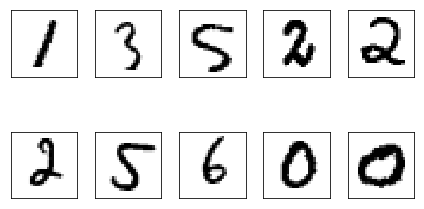

In [10]:
plt.rc('image',cmap='binary')
for i in range(10):#打印10张图
    plt.subplot(2,5,i+1)
    # 打印图用imshow
    plt.imshow(train_x[i].reshape(28,28))
    print(train_y[i])
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show

## 全连接神经网络

In [11]:
# Sequential 相当于pipeline，会自动执行forward和bp
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [12]:
def model1():
    model=Sequential()
    model.add(Dense(784,activation='relu'))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy')
    return model

In [13]:
m = model1()

In [14]:
# m.summary()

In [15]:
history = m.fit(train_x,train_y,epochs=10,batch_size=32)

Epoch 1/10
20000/20000 [==============================] - 11s 541us/step - loss: 0.3057
Epoch 2/10
20000/20000 [==============================] - 11s 559us/step - loss: 0.1275
Epoch 3/10
20000/20000 [==============================] - 10s 497us/step - loss: 0.0873
Epoch 4/10
20000/20000 [==============================] - 10s 477us/step - loss: 0.0628
Epoch 5/10
20000/20000 [==============================] - 9s 473us/step - loss: 0.0513
Epoch 6/10
20000/20000 [==============================] - 9s 473us/step - loss: 0.0378
Epoch 7/10
20000/20000 [==============================] - 9s 471us/step - loss: 0.0317
Epoch 8/10
20000/20000 [==============================] - 10s 475us/step - loss: 0.0274
Epoch 9/10
20000/20000 [==============================] - 10s 480us/step - loss: 0.0261
Epoch 10/10
20000/20000 [==============================] - 9s 473us/step - loss: 0.0238


In [19]:
pred = m.predict(test_x)

In [20]:
from sklearn.metrics import accuracy_score

In [21]:
accuracy_score(pred.argmax(1),test_y.argmax(1))

0.9676

## 卷积神经网络RNN

In [ ]:
model_dir='models'
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

## LeNet

In [22]:
# 不像TensorFlow一样有GPU和CPU版本，安装的时候pytorch会自动识别CPU还是GPU
import torch
# nn就是各种层
import torch.nn as nn
import torch.nn.functional as F
# optim是优化器
import torch.optim as optim
# torchvision有optim的一些东西
import torchvision
# trainsforms相当于pipeline
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [23]:
import os 
import random
import numpy as np 

In [24]:
# 定一个transforms
# compose相当于一个pipeline，链式调用
data_trans = transforms.Compose([
    transforms.Resize(32),   # resize是防止在多层网络中图像提前变成1*1
    transforms.ToTensor()
#    transforms.Normalize(()())?<-参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
])

## 图像的Normalize

- 目的：将图片进行归一化的缩放|(x-mean)/std
    - 如果不归一化，可能导致梯度爆炸或者梯度衰减、梯度为零。矩阵是相乘的，网络越深，连乘越多。如果梯度都大于1就会越乘越大，导致梯度爆炸，上溢出；如果梯度小于1，会越来越小，最终导致梯度为0。

- 思考：图片归一化后，真的不存在小于0或者大于1的outlier了吗？ 
    - 不一定，如果数据不均匀，可能导致小于0或者大于1的数据。

- 思考：归一化哪部分数据？A 训练集 B 评测集 C 训练集+评测集？ A

In [25]:
np.mean(mnist.test.images)

0.13251463

In [26]:
np.std(mnist.test.images)

0.31048033

In [27]:
data_trans=transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))#参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
])

In [28]:
train_data=datasets.MNIST('data',train=True,download=True,transform=data_trans)
test_data=datasets.MNIST('data',train=False,download=True,transform=data_trans)

In [29]:
n_train=int(len(train_data)*0.9)
n_validation=len(train_data)-n_train

In [30]:
train_data,valid_data=torch.utils.data.random_split(train_data,[n_train,n_validation])

In [31]:
print(len(train_data),len(valid_data),len(test_data))

54000 6000 10000


In [32]:
batch_size=64

- 目前完成了数据集的制作

In [33]:
train_iterator=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size)
valid_iterator=torch.utils.data.DataLoader(valid_data,batch_size=batch_size)
test_iterator=torch.utils.data.DataLoader(test_data,batch_size=batch_size)

In [34]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        #第一层conv1卷积层，in_channel=1,output_channel=6,kernel_size=5*5,input_size=32*32,output_size=28*28
        self.conv1=nn.Conv2d(1,6,5)
        #第二层conv2，output_channel=6 ,kernel 5*5,output_size=10*10,input_size=14*14
        self.conv2=nn.Conv2d(6,16,5)
        
        self.fc1=nn.Linear(16*5*5,120)
        
        self.fc2=nn.Linear(120,80)
        
        self.fc3=nn.Linear(80,10)#不用增加softmax层，在cross_entropy的Loss中自动增加了Softmax
        
    def forward(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),2)
        x=F.max_pool2d(F.relu(self.conv2(x)),2)
        x=x.view(x.shape[0],-1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

- 到此神经网络定义完毕

## 载入模型并训练

In [35]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
device

device(type='cpu')

In [37]:
model=LeNet().to(device)

In [38]:
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

In [39]:
optimizer=optim.Adam(model.parameters())

In [40]:
criterion=nn.CrossEntropyLoss()

## 如何评价
- 计算精确度

In [41]:
def accu(fx,y):
    pred=fx.max(1,keepdim=True)[1]
    correct=pred.eq(y.view_as(pred)).sum()#得到该batch的准确度
    acc=correct.float()/pred.shape[0]
    return acc

In [42]:
def train(model,device,iterator,optimizer,criterion):
    epoch_loss=0#积累变量
    epoch_acc=0#积累变量
    model.train()#该函数表示PHASE=Train
    
    for (x,y) in iterator:#拿去每一个minibatch
        x=x.to(device)
        y=y.to(device)
        optimizer.zero_grad()
        fx=model(x)#进行forward
        loss=criterion(fx,y)#计算Loss,train_loss
        type(loss)
        acc=accu(fx,y)#计算精确度，train_accu
        loss.backward()#进行BP
        optimizer.step()#统一更新模型
        epoch_loss+=loss.item()
        epoch_acc+=acc.item()
        
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

In [43]:
def evaluate(model,device,iterator,criterion):
    epoch_loss=0
    epoch_acc=0
    model.eval()
    with torch.no_grad():
        for (x,y) in iterator:
            x=x.to(device)
            y=y.to(device)
            fx=model(x)
            loss=criterion(fx,y)
            acc=accu(fx,y)
            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

## 开始训练

In [44]:
epochs=10
model_path=os.path.join(model_dir,'lenet_mnist.pt')

In [45]:
best_valid_loss=float('inf')

In [47]:
for epoch in range(epochs):
    train_loss,train_acc=train(model,device,train_iterator,optimizer,criterion)
    valid_loss,valid_acc=evaluate(model,device,valid_iterator,criterion)
    if valid_loss<best_valid_loss:#如果是最好的模型就保存到文件夹
        best_valid_loss=valid_loss
        torch.save(model.state_dict(),model_path)
    print('Epoch:{0}|Train Loss:{1}|Train Acc:{2}|Val Loss:{3}|Val Acc:{4}'.format(epoch+1,train_loss,train_acc,valid_loss,valid_acc))

Epoch:1|Train Loss:0.24760320014651352|Train Acc:0.9246642970219607|Val Loss:0.10908676905834928|Val Acc:0.9671431735475012
Epoch:2|Train Loss:0.07427523002222675|Train Acc:0.976815511476937|Val Loss:0.08388522075132486|Val Acc:0.9747340425531915
Epoch:3|Train Loss:0.053126079695723|Train Acc:0.9832642180094787|Val Loss:0.06838884665333528|Val Acc:0.981216755319149
Epoch:4|Train Loss:0.040222542934225634|Train Acc:0.9871149289099526|Val Loss:0.05522994688177045|Val Acc:0.983876329787234
Epoch:5|Train Loss:0.03392185422402069|Train Acc:0.9893241508453379|Val Loss:0.053868640603081504|Val Acc:0.9833776595744681
Epoch:6|Train Loss:0.028590797192871713|Train Acc:0.9906632602921029|Val Loss:0.047937486177072566|Val Acc:0.9876994680851063
Epoch:7|Train Loss:0.023947799947969087|Train Acc:0.9924281694312796|Val Loss:0.045031971159450554|Val Acc:0.9870345744680851
Epoch:8|Train Loss:0.020562630354192868|Train Acc:0.9932427428909952|Val Loss:0.04872167399066421|Val Acc:0.987533244680851
Epoch:9

In [48]:
model.load_state_dict(torch.load(model_path))

test_loss, test_acc = evaluate(model, device, test_iterator, criterion)

print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))

| Test Loss: 0.0347950556760381 | Test Acc: 0.9887539808917197 |


## AlexNet

In [112]:
torch.set_num_threads(100)

In [113]:
data_trans_alexnet = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))#参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
])
train_data = datasets.MNIST('data',train=True,download=True,transform=data_trans_alexnet)
test_data = datasets.MNIST('data',train=False,download=True,transform=data_trans_alexnet)

In [114]:
n_train=int(len(train_data)*0.9)
n_validation=len(train_data)-n_train

In [115]:
train_data,valid_data=torch.utils.data.random_split(train_data,[n_train,n_validation])

In [116]:
print(len(train_data),len(valid_data),len(test_data))

54000 6000 10000


In [117]:
batch_size = 64

In [118]:
train_iterator=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size)
valid_iterator=torch.utils.data.DataLoader(valid_data,batch_size=batch_size)
test_iterator=torch.utils.data.DataLoader(test_data,batch_size=batch_size)

In [119]:
class AlexNet(nn.Module):
    def __init__(self):#init函数定义的是网络的架构、关键的网络模块、模组
        super(AlexNet,self).__init__()
        self.feature_block=nn.Sequential(
            nn.Conv2d(1,64,kernel_size=11,stride=4,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(64,192,kernel_size=5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(192,384,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        self.avgpool=nn.AdaptiveAvgPool2d((6,6))
        self.class_block=nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096,10),
        )
    def forward(self,x):#数据的正向流
        x = self.feature_block(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),256*6*6)
        x = self.class_block(x)
        return x

In [120]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu:0')

In [121]:
model = AlexNet().to(device)

In [122]:
model

AlexNet(
  (feature_block): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (class_block): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dro

In [123]:
optimizer=optim.Adam(model.parameters())

In [124]:
criterion=nn.CrossEntropyLoss()

In [125]:
epochs=10
model_dir='models'
model_path=os.path.join(model_dir,'alexnet_mnist.pt')

In [126]:
best_valid_loss=float('inf')

In [127]:
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

In [128]:
for epoch in range(epochs):
    train_loss,train_acc=train(model,device,train_iterator,optimizer,criterion)
    valid_loss,valid_acc=evaluate(model,device,valid_iterator,criterion)
    if valid_loss<best_valid_loss:#如果是最好的模型就保存到文件夹
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),model_path)
    print('Epoch:{0}|Train Loss:{1}|Train Acc:{2}|Val Loss:{3}|Val Acc:{4}'.format(epoch+1,train_loss,train_acc,valid_loss,valid_acc))

Epoch:1|Train Loss:0.2783555006277328|Train Acc:0.9086752073459715|Val Loss:0.07011570103783557|Val Acc:0.9805518617021277


KeyboardInterrupt: 

In [129]:
model.load_state_dict(torch.load(model_path))
test_loss, test_acc = evaluate(model, device, test_iterator, criterion)
print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))

KeyboardInterrupt: 

In [ ]:
torch.__version__

In [ ]:
torchvision.__version__

In [130]:
torch.get_num_threads()

100